# PROBLEM STATEMENT

Numerous factors, such as location, size, condition, and time, may have a significant impact on a house's value, and these elements can vary significantly from one property to anothe


Since the housing market is a highly unstable sector of the economy that is highly reliant on changes in supply and demand as well as inflation and interest rates, it is difficult to forecast how prices will change over 
Because there is little data available to forecast house values, feature engineering is crucial. Most datasets only include a small number of attributes associated with each property.time.


## DATA PREPARATION

In [40]:
import os,sys,warnings
if not sys.warnoptions:    
    warnings.simplefilter('ignore')
    
import numpy as np
from numpy.linalg import pinv,inv
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set(style='whitegrid')
%matplotlib inline

In [41]:
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc

In [42]:
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, RegressorMixin,ClassifierMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
pi = 4.0*np.arctan(1.0)

color1 = 'darkviolet'
color2 = 'indigo'

In [43]:
#pip install geopandas
#!pip install geoplot

In [5]:
# Load the dataset
df = pd.read_csv('housing.csv')

In [6]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
# Check the missing value
df[df.isnull().any(axis=1)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0,NEAR OCEAN
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0,NEAR OCEAN
20372,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,<1H OCEAN
20460,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,258100.0,<1H OCEAN


# Data imputation

It is evident that there are few features with some missing data, however generally there aren't many examples (257/20640).



Let's attempt an Unsupervised Learning (UL) strategy using the kNN model. To build an imputed dataframe, we may feed a dataframe to the code beow.


In [16]:
from sklearn.neighbors import KNeighborsRegressor

# function that imputes a dataframe 
def impute_knn(df):               

    # separate dataframe into numerical/categorical
    ldf = df.select_dtypes(include=[np.number])           
    ldf_putaside = df.select_dtypes(exclude=[np.number])  
    # define columns w/ and w/o missing data
    cols_nan = ldf.columns[ldf.isna().any()].tolist()          
    cols_no_nan = ldf.columns.difference(cols_nan).values     

    for col in cols_nan:                
        imp_test = ldf[ldf[col].isna()]    
        imp_train = ldf.dropna()           
        model = KNeighborsRegressor(n_neighbors=5)  
        knr = model.fit(imp_train[cols_no_nan], imp_train[col])
        ldf.loc[df[col].isna(), col] = knr.predict(imp_test[cols_no_nan])
    
    return pd.concat([ldf,ldf_putaside],axis=1)

In [17]:
df2 = impute_knn(df)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [18]:
# 70/30 split should do
trdata, tedata = train_test_split(df2, test_size=0.3, random_state=43)

# EXPLORATORY DATA ANALYSIS

## Univariate histograms

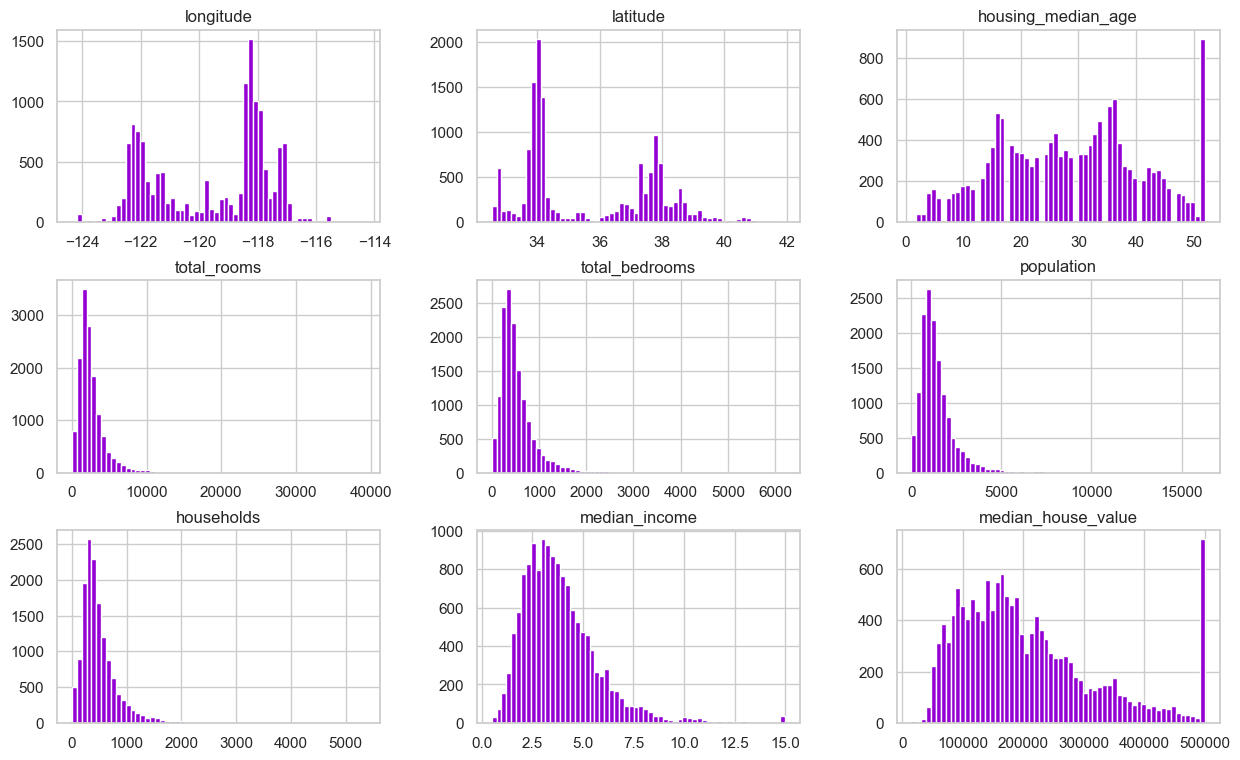

In [21]:
trdata.hist(bins=60, figsize=(15,9), color=color1)
plt.show()

# Bivariate scattered data

In [28]:
def snsPairGrid(df):

    ''' Plots a Seaborn Pairgrid w/ KDE & scatter plot of df features'''
    g = sns.PairGrid(df,diag_sharey=False)
    g.fig.set_size_inches(14,13)
    g.map_diag(sns.kdeplot, lw=2) # draw kde approximation on the diagonal
    g.map_lower(sns.scatterplot,s=15,edgecolor="k",linewidth=1,alpha=0.4) # scattered plot on lower half
    g.map_lower(sns.kdeplot,cmap='plasma',n_levels=10) # kde approximation on lower half
    plt.tight_layout()

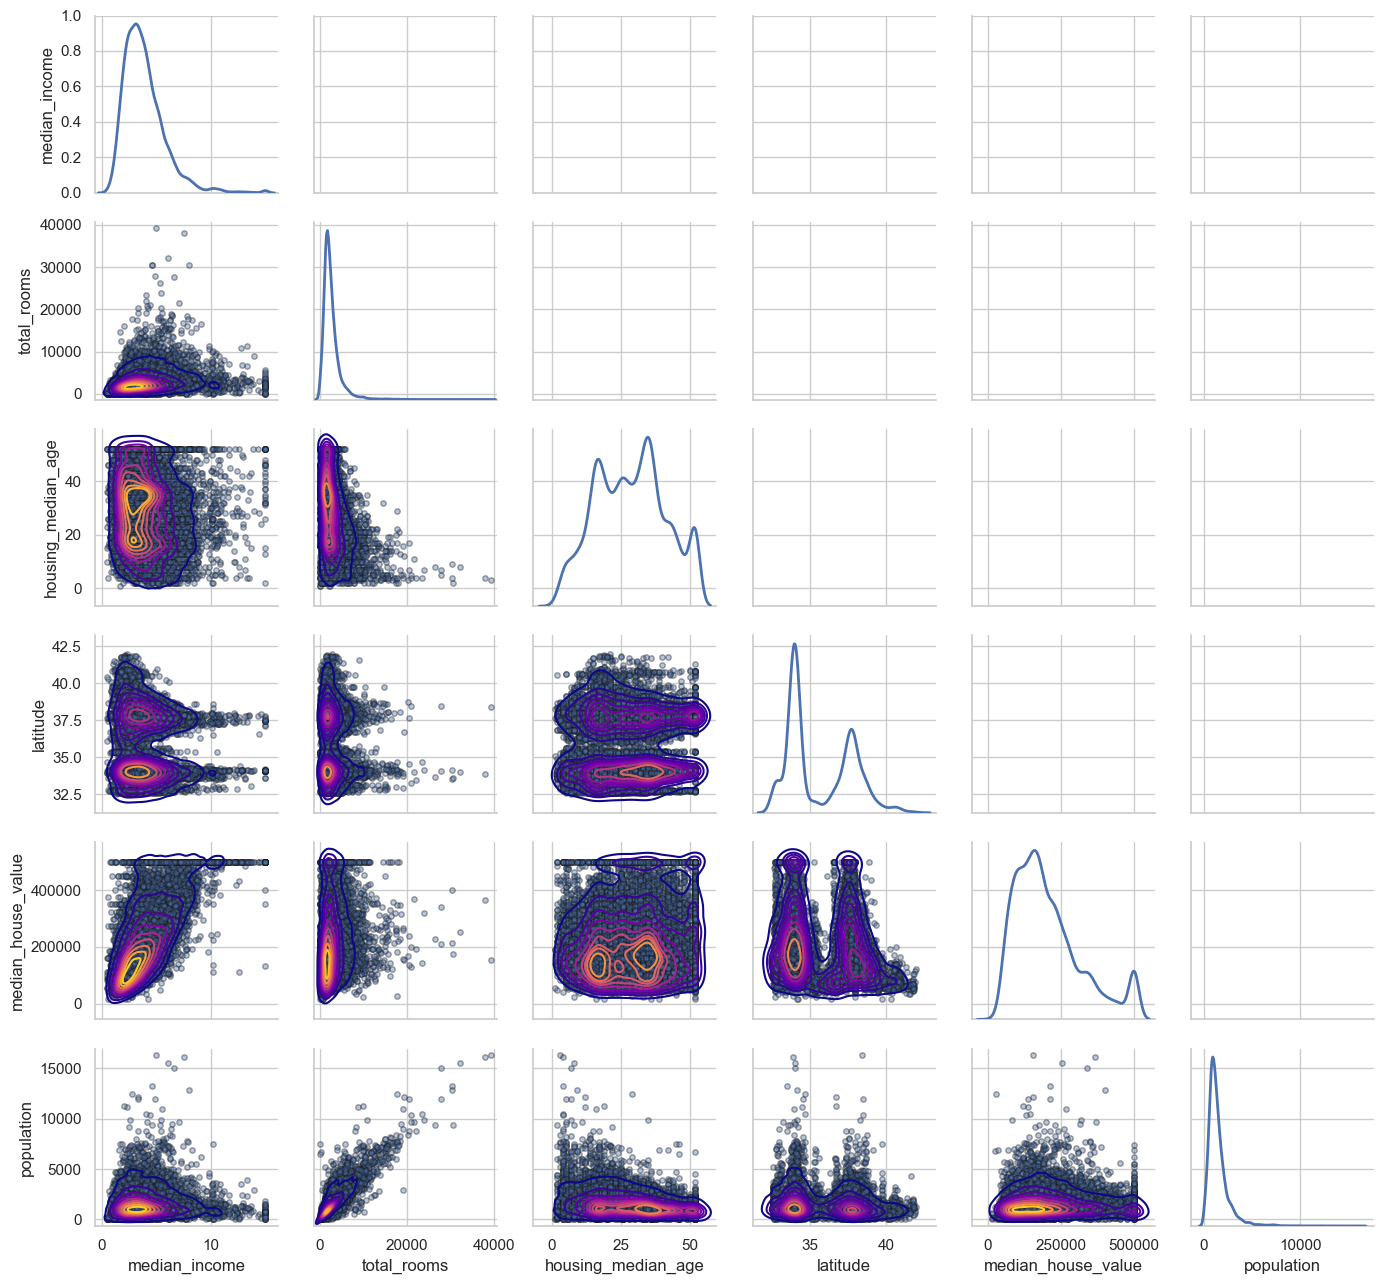

In [29]:
tlist = ['median_income','total_rooms','housing_median_age','latitude','median_house_value','population']
snsPairGrid(trdata[tlist]) 

# multivariative data

In [44]:
def plotTwo(df,lst):
    
    # load california from module, common for all plots
    cali = gpd.read_file(gplt.datasets.get_path('california_congressional_districts'))
    cali = cali.assign(area=cali.geometry.area)
    
    # Create a geopandas geometry feature; input dataframe should contain .longtitude, .latitude
    gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.longitude,df.latitude))
    proj=gcrs.AlbersEqualArea(central_latitude=37.16611, central_longitude=-119.44944) # related to view

    ii=-1
    fig,ax = plt.subplots(1,2,figsize=(21,6),subplot_kw={'projection': proj})
    for i in lst:

        ii+=1
        tgdf = gdf.sort_values(by=i,ascending=True) 
        gplt.polyplot(cali,projection=proj,ax=ax[ii]) # the module already has california 
        gplt.pointplot(tgdf,ax=ax[ii],hue=i,cmap='plasma',legend=True,alpha=1.0,s=3) # 
        ax[ii].set_title(i)

    plt.tight_layout()
    plt.subplots_adjust(wspace=-0.5)

In [45]:
trdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14448 entries, 11440 to 14148
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           14448 non-null  float64
 1   latitude            14448 non-null  float64
 2   housing_median_age  14448 non-null  float64
 3   total_rooms         14448 non-null  float64
 4   total_bedrooms      14448 non-null  float64
 5   population          14448 non-null  float64
 6   households          14448 non-null  float64
 7   median_income       14448 non-null  float64
 8   median_house_value  14448 non-null  float64
 9   ocean_proximity     14448 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.2+ MB


In [46]:
import geopandas as gpd
from shapely.geometry import Point

KeyError: 'geometry'

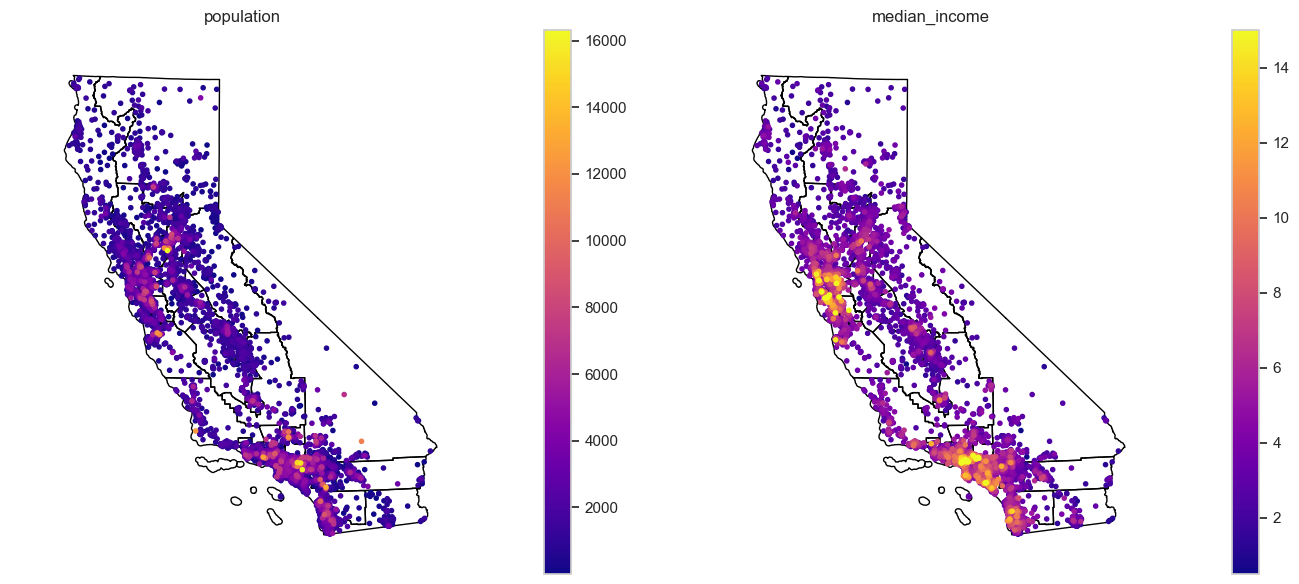

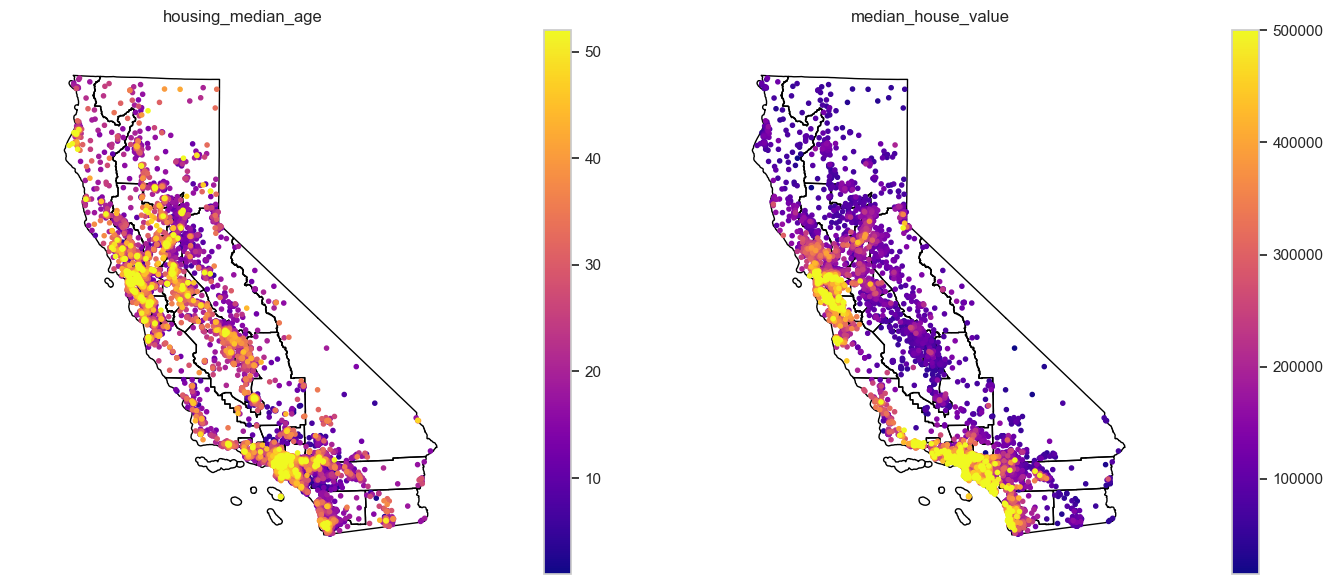

In [48]:
# Call function that plots two geopandas plots 
plotTwo(trdata,['population','median_income'])
plotTwo(trdata,['housing_median_age','median_house_value'])
trdata['geometry'] # not useful for anything other than gpd visualisation

# OUTLIERS

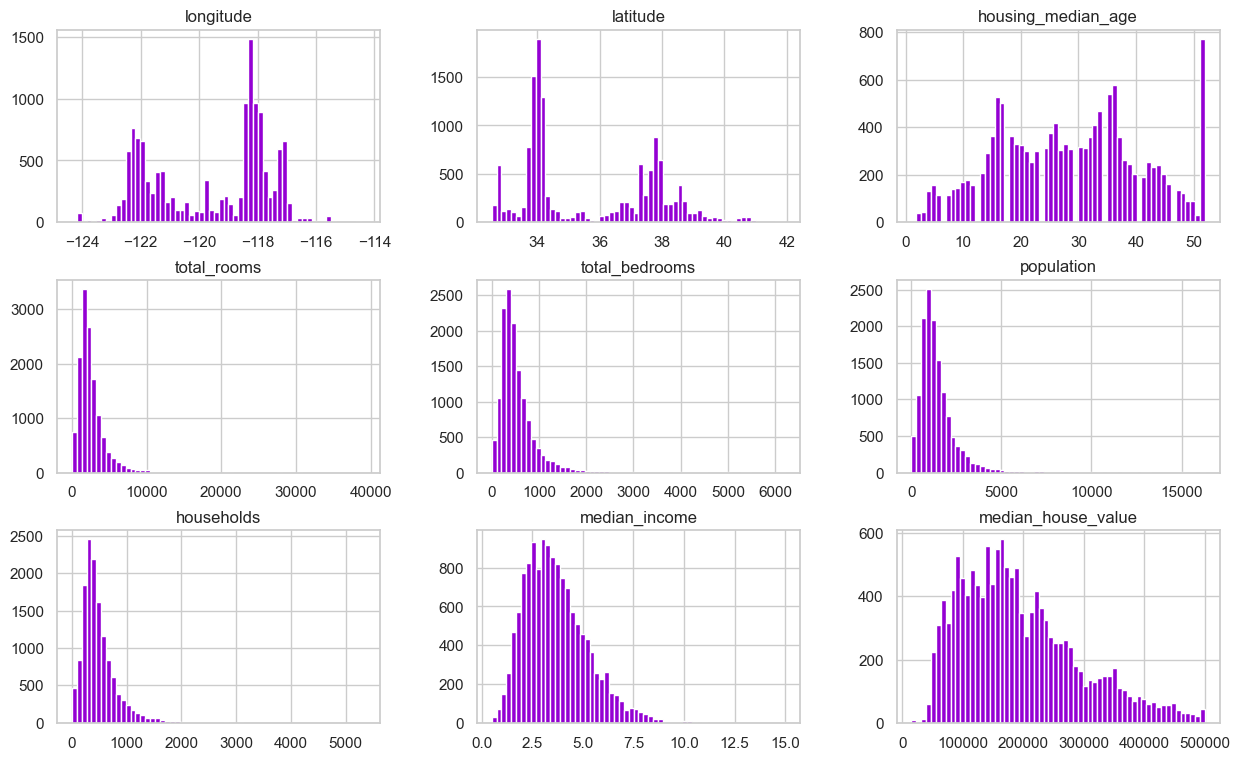

In [51]:
maxval2 = trdata['median_house_value'].max() # get the maximum value
trdata_upd = trdata[trdata['median_house_value'] != maxval2] 
tedata_upd = tedata[tedata['median_house_value'] != maxval2]
trdata_upd.hist(bins=60, figsize=(15,9),color=color1);plt.show()

# feature engineering

KeyError: 'geometry'

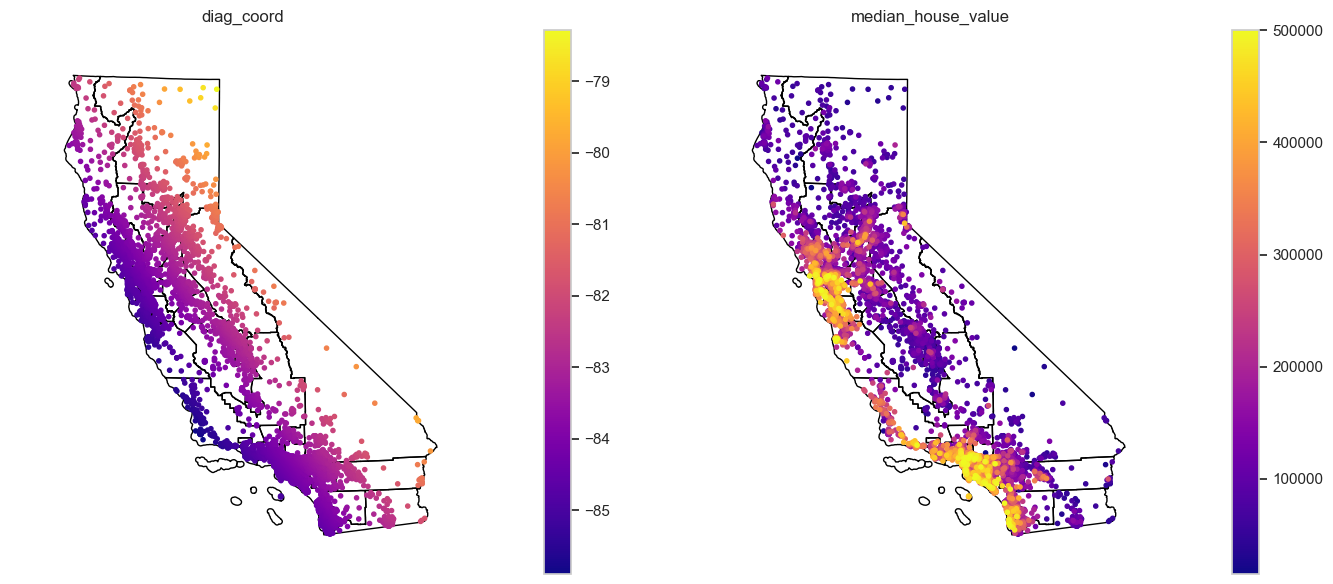

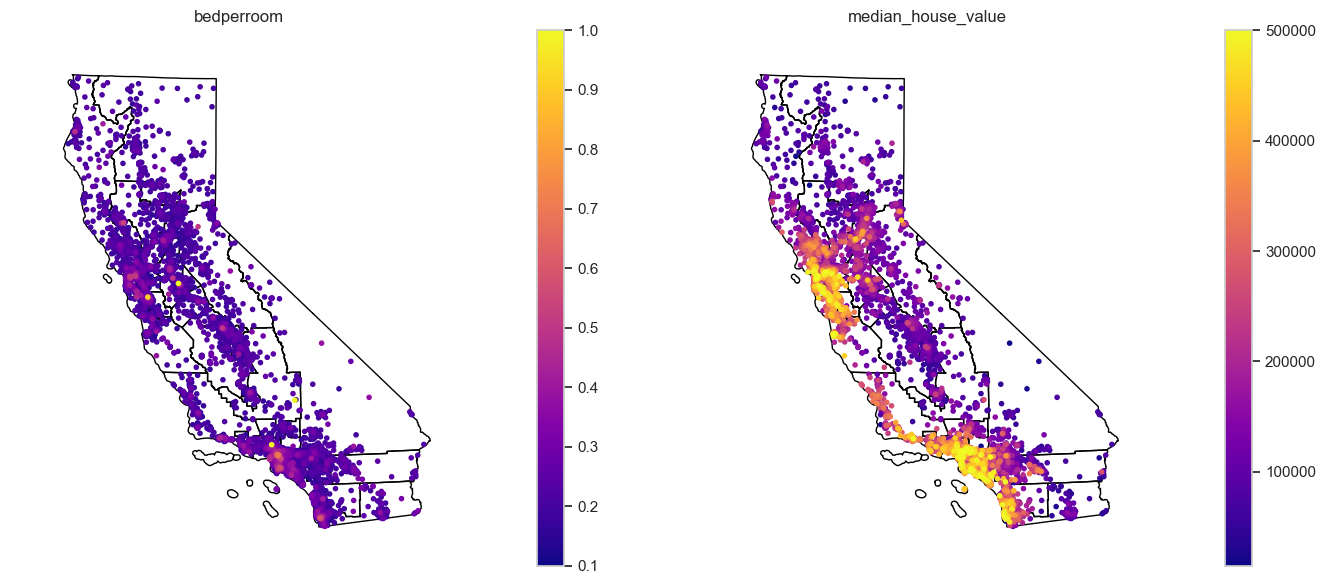

In [58]:
# lets plot them as well
plotTwo(trdata_upd,['diag_coord','median_house_value'])
plotTwo(trdata_upd,['bedperroom','median_house_value'])
del trdata_upd['geometry']  # remove gpd geometry features

In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import geopandas as gpd
from shapely.geometry import Point

In [68]:
# Load your dataset
data = pd.read_csv('housing.csv')

In [69]:
# Convert to GeoDataFrame and create 'geometry' column
data['geometry'] = data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
geo_data = gpd.GeoDataFrame(data, geometry='geometry')

In [70]:
# Preprocess the data
# Handle missing values
geo_data = geo_data.dropna()

In [71]:
# Encode categorical variables (if any)
geo_data = pd.get_dummies(geo_data, columns=['ocean_proximity'], drop_first=True)


In [72]:
# Split the data into features and target variable
X = geo_data.drop(['median_house_value', 'geometry'], axis=1)
y = geo_data['median_house_value']

In [73]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [75]:
# Apply KNN algorithm
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor()

In [76]:
# Make predictions
y_pred = knn.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [77]:
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 62203.28008397312


In [78]:
# Plotting function
def plotTwo(df, columns):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    for i, col in enumerate(columns):
        df.plot(column=col, ax=axes[i], legend=True)
        axes[i].set_title(col)
    plt.show()

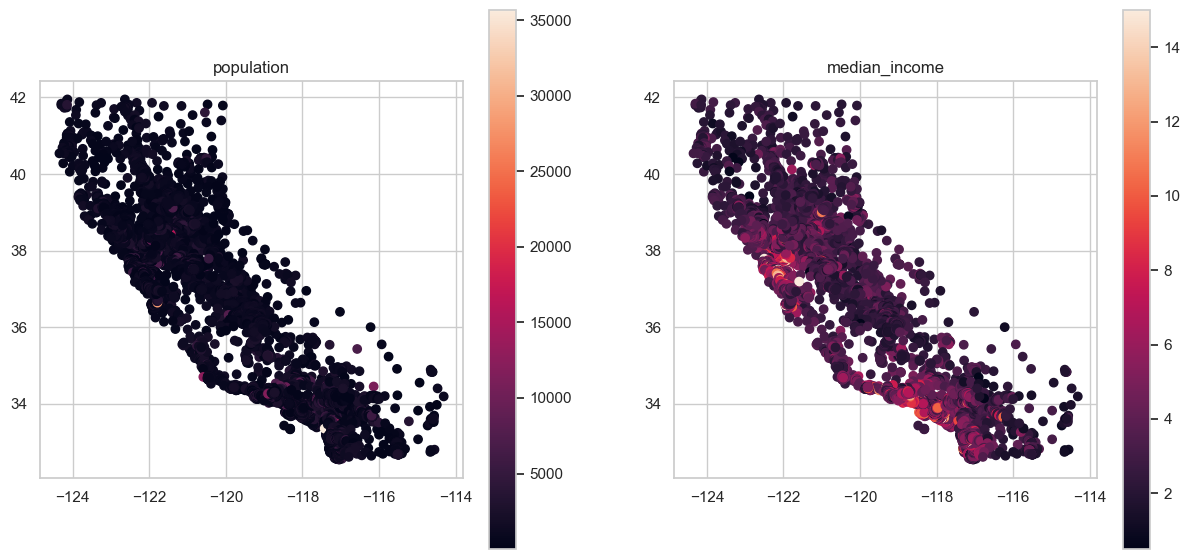

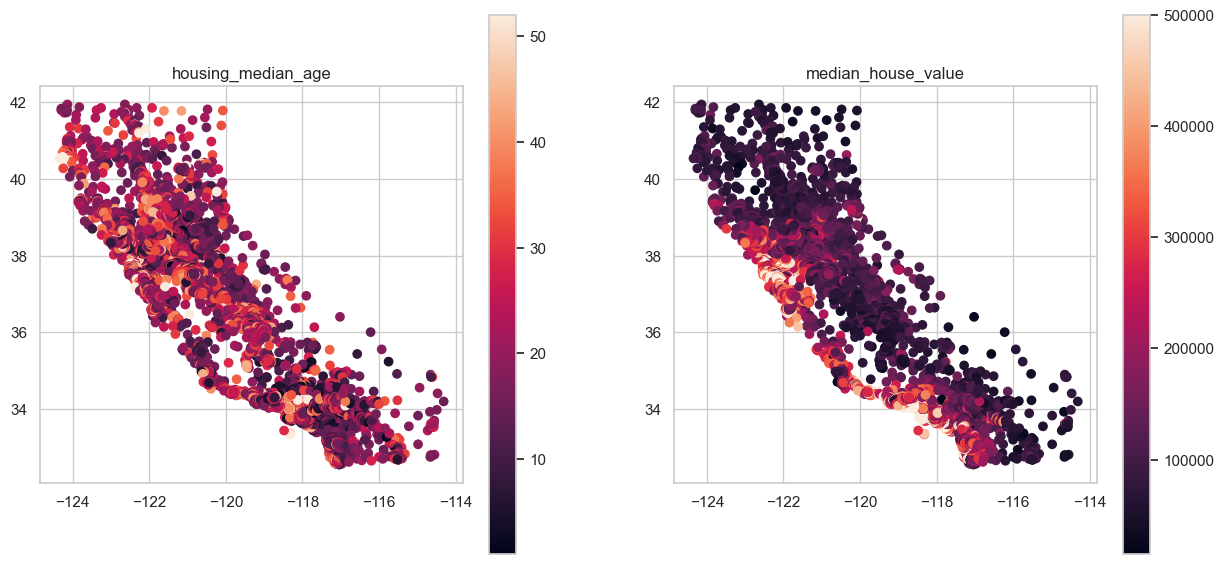

In [79]:
# Call function that plots two geopandas plots
plotTwo(geo_data, ['population', 'median_income'])
plotTwo(geo_data, ['housing_median_age', 'median_house_value'])

In [81]:
# Check if 'geometry' column exists before deleting
if 'geometry' in geo_data.columns:
    del geo_data['geometry']
else:
    print("'geometry' column not found in geo_data")


'geometry' column not found in geo_data
